In [1]:
# Correlation plots

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMitosisExt
Wed Jun 29 08:35:18 PDT 2022


In [3]:
import os
import sys
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from sklearn.decomposition import PCA
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
path_cvapipe = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control_main = controller.Controller(general.load_config_file(path_cvapipe))

In [5]:
datasets = {
    "control": f"{path_cvapipe}/local_staging_variance_m1m2",
    "perturbed": f"{path_cvapipe}/local_staging_m1m2"
}

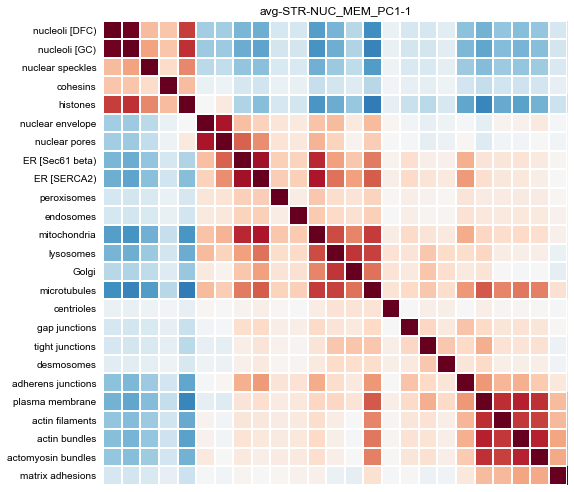

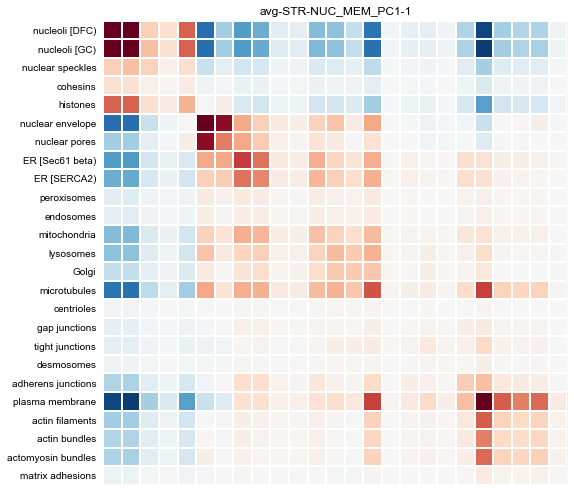

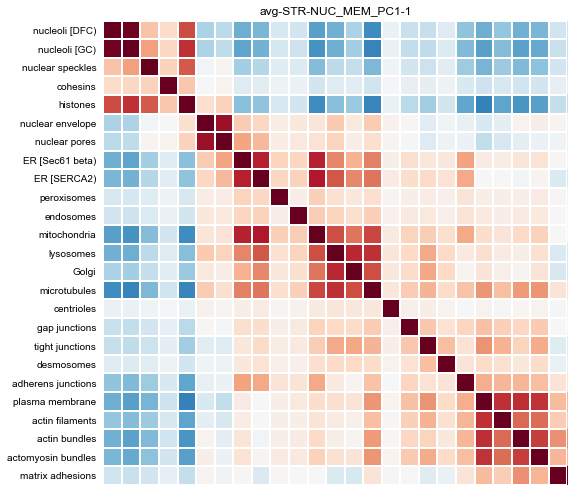

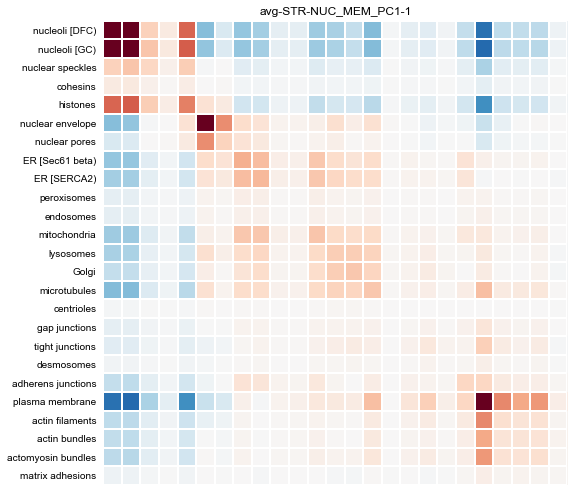

In [15]:
for dsname, dspath in datasets.items():
    
    config = general.load_config_file(Path(dspath)/"correlation", fname="parameters.yaml")
    control = controller.Controller(config)
    device = io.LocalStagingIO(control)
    
    variables = control.get_variables_values_for_aggregation()
    df_agg = shapespace.ShapeSpaceBasic.get_aggregated_df(variables)
    df_agg = df_agg.drop(columns=["structure"]).drop_duplicates().reset_index(drop=True)
    row = df_agg.loc[df_agg.index[0]]

    for mode in ["CORR_OF_AVG_REP", "AVG_CORR_OF_REPS"]:
        
        plotter = plotting.ConcordancePlotMaker(control_main)
        if mode == "CORR_OF_AVG_REP":
            corr = device.build_correlation_matrix_of_avg_reps_from_corr_values(row, genes=control_main.get_gene_names())
#             np.fill_diagonal(corr, np.nan)
        else:
            corr = device.read_corelation_matrix(row)
            corr = plotter.get_aggregated_matrix_from_df(control_main.get_gene_names(), corr)
            plotter.set_heatmap_min_max_values(-0.2, 0.2)

        pd.DataFrame(corr).to_csv(f"m1_{mode}_{dsname}.csv", index=False, header=False, sep="\t")
            
        plotter.set_row(row)
        plotter.make_heatmap(corr, display=True)
        plotter.figs[0][0].savefig(f"FigureMitosisExt4_{mode}_{dsname}.pdf")

In [7]:
corr = {}
for dsname, dspath in datasets.items():
    
    config = general.load_config_file(Path(dspath)/"correlation", fname="parameters.yaml")
    control = controller.Controller(config)
    device = io.LocalStagingIO(control)
    
    variables = control.get_variables_values_for_aggregation()
    df_agg = shapespace.ShapeSpaceBasic.get_aggregated_df(variables)
    df_agg = df_agg.drop(columns=["structure"]).drop_duplicates().reset_index(drop=True)
    row = df_agg.loc[df_agg.index[0]]
        
    plotter = plotting.ConcordancePlotMaker(control)
    mx = device.read_corelation_matrix(row)
    mx = plotter.get_aggregated_matrix_from_df(control.get_gene_names(), mx)
    corr[dsname] = mx

'avg-STR-NUC_MEM_PC1-1'

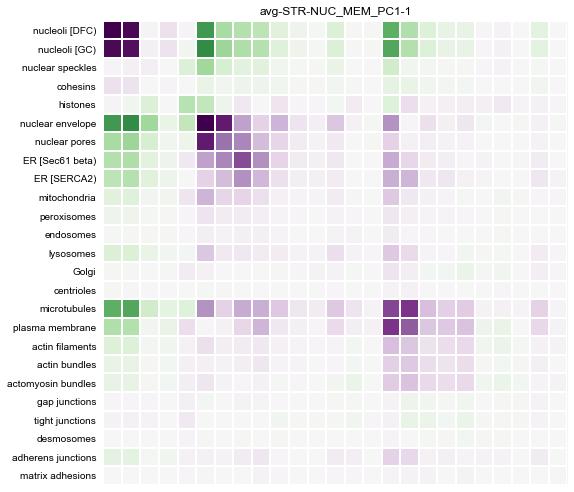

In [8]:
plotter = plotting.ConcordancePlotMaker(control)
plotter.set_heatmap_min_max_values(-0.1, 0.1)
plotter.set_row(row)
plotter.make_heatmap(corr["control"]-corr["perturbed"], display=True, cmap="PRGn")

In [9]:
common.now("complete")

complete 2022-06-29 08:35:41
